In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from mango import scheduler, Tuner

In [2]:
ds = pd.read_excel(r'RETAIL.xlsx', decimal=',')

df = pd.DataFrame(ds, columns=['date', 'sales'])

df

,date,sales
0,1991-01-01,11297
1,1991-02-01,10064
2,1991-03-01,10883
3,1991-04-01,11052
4,1991-05-01,11960
...,...,...
116,2000-09-01,18901
117,2000-10-01,18856
118,2000-11-01,17856
119,2000-12-01,17647


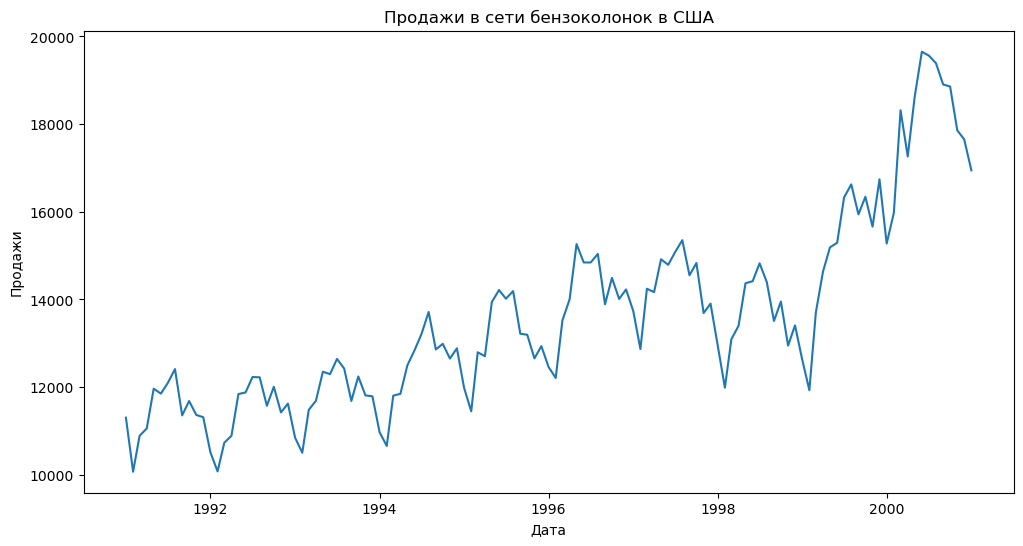

In [3]:
df['date'] = pd.to_datetime(df['date'])

plt.figure(figsize=(12, 6))
plt.plot(df['date'], df['sales'])
plt.title('Продажи в сети бензоколонок в США')
plt.xlabel('Дата')
plt.ylabel('Продажи')
plt.show()

In [4]:
result = adfuller(df['sales'])
print('ADF статистика:', result[0])
print('p-значение:', result[1])
print('Критические значения:')
for key, value in result[4].items():
    print(f'  {key}: {value}')

ADF статистика: -0.40032350450184057
p-значение: 0.9100447496818846
Критические значения:
  1%: -3.4924012594942333
  5%: -2.8886968193364835
  10%: -2.5812552709190673


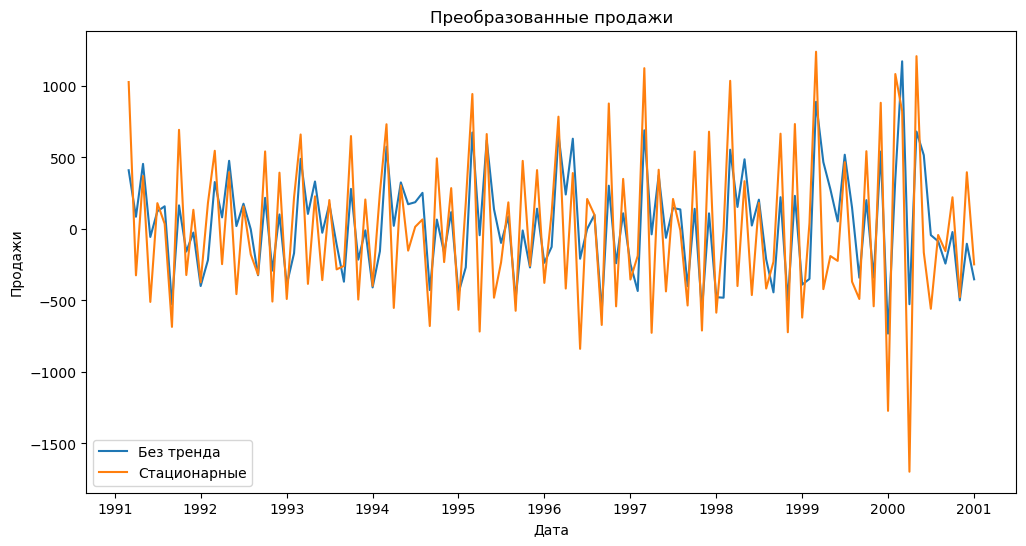

In [5]:
df['non_trand_sales'] = df['sales'] - df['sales'].rolling(window=2).mean()

df['sales_stat'] = df['non_trand_sales'].diff()

df.dropna(inplace=True)

# Построим графики
plt.figure(figsize=(12, 6)) 
plt.plot(df['date'], df['non_trand_sales'], label='Без тренда')
plt.plot(df['date'], df['sales_stat'], label='Стационарные')
plt.legend()
plt.title('Преобразованные продажи')
plt.xlabel('Дата')
plt.ylabel('Продажи')
plt.show()

In [6]:
result = adfuller(df['sales_stat'])
print('ADF статистика:', result[0])
print('p-значение:', result[1])
print('Критические значения:')
for key, value in result[4].items():
    print(f'  {key}: {value}')

ADF статистика: -4.151945088032048
p-значение: 0.0007937944656178085
Критические значения:
  1%: -3.4942202045135513
  5%: -2.889485291005291
  10%: -2.5816762131519275


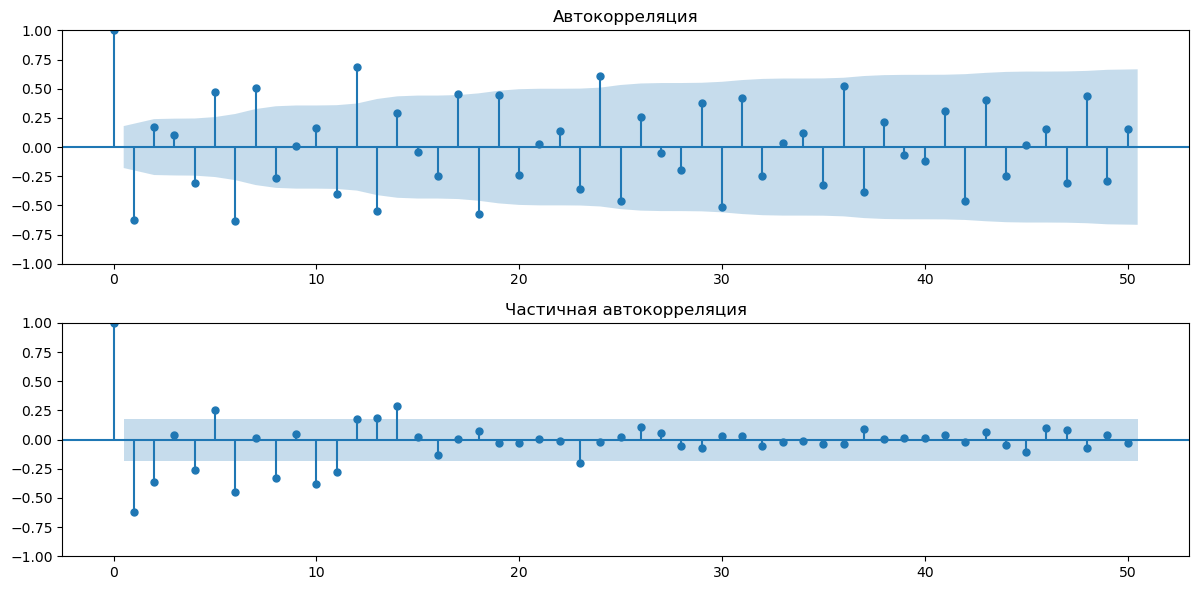

In [7]:
plt.figure(figsize=(12, 6))
plt.subplot(211)
plot_acf(df['sales_stat'], lags=50, ax=plt.gca())
plt.title('Автокорреляция')

plt.subplot(212)
plot_pacf(df['sales_stat'], lags=50, ax=plt.gca())
plt.title('Частичная автокорреляция')

plt.tight_layout()
plt.show()

In [8]:
p = 1
d = 1
q = 1

model = ARIMA(df['sales_stat'], order=(p, d, q))
model_fit = model.fit()

print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:             sales_stat   No. Observations:                  119
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -884.283
Date:                Thu, 09 May 2024   AIC                           1774.565
Time:                        00:38:34   BIC                           1782.877
Sample:                             0   HQIC                          1777.940
                                - 119                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6338      0.089     -7.116      0.000      -0.808      -0.459
ma.L1         -0.9998     11.916     -0.084      0.933     -24.354      22.355
sigma2      1.806e+05   2.16e+06      0.084      0.9

In [9]:
# Прогноз на основе обученной модели
forecast = model_fit.forecast(steps=12)

# Рассчитываем MSE и MAE
mse = mean_squared_error(df['sales'][-12:], forecast)
mae = mean_absolute_error(df['sales'][-12:], forecast)

print(f'MSE: {mse}')
print(f'MAE: {mae}')

MSE: 333906986.21203995
MAE: 18238.46924231665


In [10]:
def arima_objective_function(args_list):
    global data_values
    
    params_evaluated = []
    results = []
    
    for params in args_list:
        try:
            p,d,q = params['p'],params['d'], params['q']
            trend = params['trend']
            
            model = ARIMA(data_values, order=(p,d,q), trend = trend)
            predictions = model.fit()
            mse = mean_squared_error(data_values, predictions.fittedvalues)   
            params_evaluated.append(params)
            results.append(mse)
        except:
            #print(f"Exception raised for {params}")
            #pass 
            params_evaluated.append(params)
            results.append(1e5)
        
        #print(params_evaluated, mse)
    return params_evaluated, results

param_space = dict(p= range(0, 30),
                   d= range(0, 1),
                   q =range(0, 30),
                   trend = ['n', 'c', 't', 'ct']
                  )

conf_Dict = dict()
conf_Dict['num_iteration'] = 200
data_values = list(df['sales'])
tuner = Tuner(param_space, arima_objective_function, conf_Dict)
results = tuner.minimize()
print('best parameters:', results['best_params'])
print('best loss:', results['best_objective'])

  0%|          | 0/200 [00:00<?, ?it/s]

best parameters: {'d': 0, 'p': 29, 'q': 18, 'trend': 'ct'}
best loss: 82463.93890808256


{'d': 0, 'p': 29, 'q': 18, 'trend': 'ct'}
final model: (29, 0, 18) ct
MSE error is: 82463.93890808256


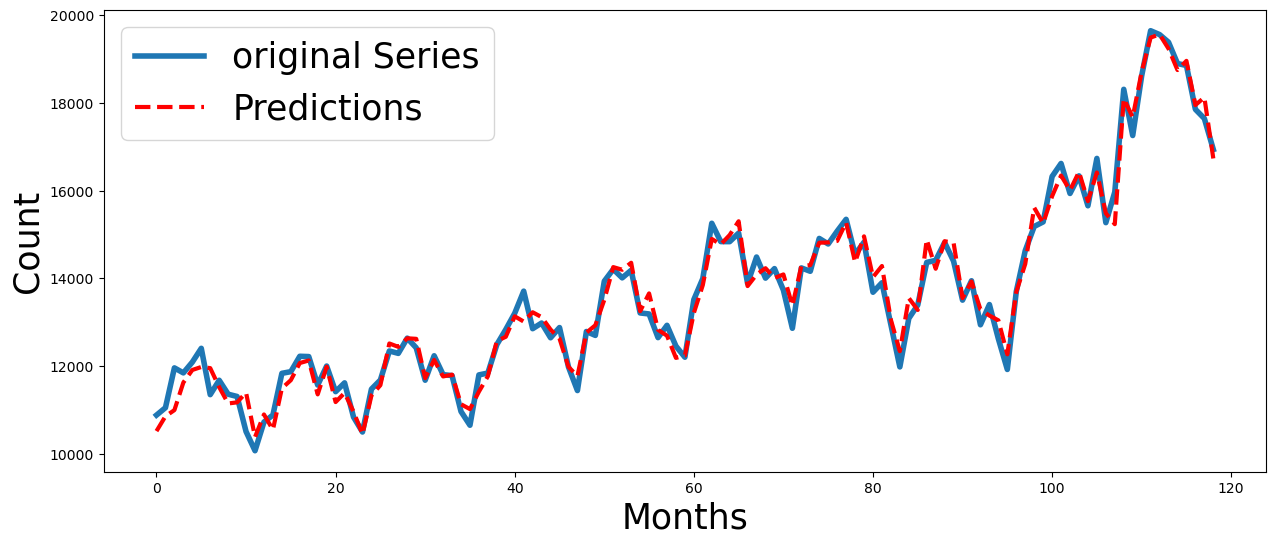

In [11]:
def plot_arima(data_values, order=(1, 1, 1), trend=None):
    print('final model:', order, trend)
    model = ARIMA(data_values, order=order, trend=trend)
    results = model.fit()
    
    error = mean_squared_error(data_values, results.fittedvalues)   
    print('MSE error is:', error)
    
    from matplotlib import pyplot as plt
    f = plt.figure()
    f.set_figwidth(15)
    f.set_figheight(6)
    plt.plot(data_values, label="original Series", linewidth=4)
    plt.plot(results.fittedvalues, color='red', label="Predictions", linestyle='dashed', linewidth=3)
    plt.legend(fontsize=25)
    plt.xlabel('Months', fontsize=25)
    plt.ylabel('Count', fontsize=25)
    plt.show()

print(results['best_params'])

order = (results['best_params']['p'], results['best_params']['d'], results['best_params']['q'])
plot_arima(data_values, order=order, trend = results['best_params']['trend'])